In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [2]:
boron_regio = pd.read_csv("borylation_regio.csv")

In [3]:
smiles = boron_regio.Reactant_SMILES.unique()
smiles = set([Chem.CanonSmiles(s) for s in smiles])

carbon_cts = []
for smiles in smiles:
    mol = Chem.MolFromSmiles(smiles)
    num_C = [atom.GetAtomicNum() for atom in mol.GetAtoms()].count(6)
    carbon_cts.append(num_C)

(array([13., 22., 18.,  4.,  0.,  3., 10.,  7.,  0.,  1.]),
 array([ 7. ,  8.8, 10.6, 12.4, 14.2, 16. , 17.8, 19.6, 21.4, 23.2, 25. ]),
 <BarContainer object of 10 artists>)

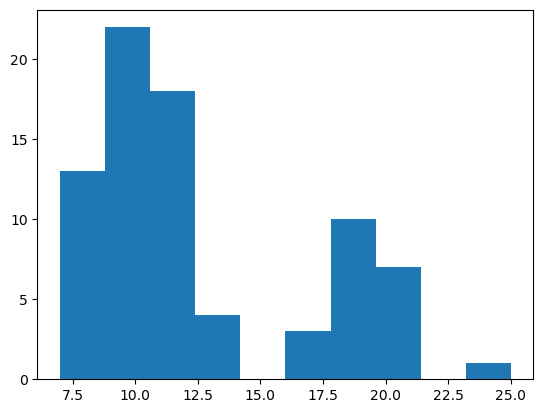

In [4]:
plt.hist(carbon_cts)

In [5]:
print(len([c for c in carbon_cts if c > 15]), "molecules with > 15 carbons.")
print(len([c for c in carbon_cts if c <= 15]), "molecules with <= 15 carbons.")

21 molecules with > 15 carbons.
57 molecules with <= 15 carbons.


In [6]:
def group_symmetric_atoms(smiles):
    """
    input : reactant Canonical SMILES
    output:
        mol, Chem.Mol() object annotated with the symmetry group atoms are belonging to
        idx_to_group, dict() with keys being atom idx in the CanonicalSMILES and values beig the label of the group they belong to.
    """
    
    smiles = Chem.CanonSmiles(smiles)
    mol    = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol)
    groups = Chem.CanonicalRankAtoms(mol, breakTies=False)
    
    idx_to_group = {}
    
    for at in mol.GetAtoms():
        at.SetProp('atomNote', f"{groups[at.GetIdx()]}")  
        if at.GetSymbol() == 'C':
            idx_to_group.update({at.GetIdx(): groups[at.GetIdx()]})

    return mol, idx_to_group

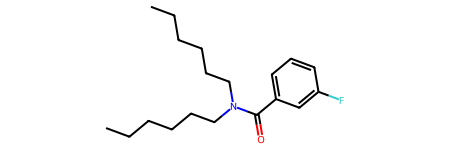

In [7]:
s = "CCCCCCN(CCCCCC)C(=O)c1cccc(F)c1"
Chem.MolFromSmiles(s)


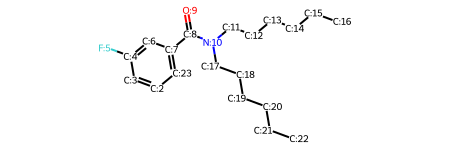

In [8]:
r_map = "[cH:2]1[cH:3][c:4]([F:5])[cH:6][c:7]([C:8](=[O:9])[N:10]([CH2:11][CH2:12][CH2:13][CH2:14][CH2:15][CH3:16])[CH2:17][CH2:18][CH2:19][CH2:20][CH2:21][CH3:22])[cH:23]1"
p_map = "[BH2:1][c:2]1[cH:3][c:4]([F:5])[cH:6][c:7]([C:8](=[O:9])[N:10]([CH2:11][CH2:12][CH2:13][CH2:14][CH2:15][CH3:16])[CH2:17][CH2:18][CH2:19][CH2:20][CH2:21][CH3:22])[cH:23]1"
Chem.MolFromSmiles(r_map)


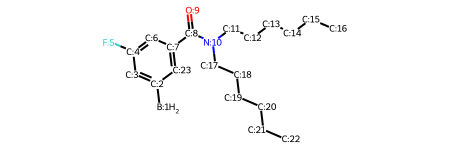

In [9]:
Chem.MolFromSmiles(p_map)

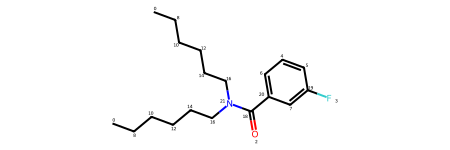

In [10]:
group_symmetric_atoms(s)[0]

In [11]:
import sys
import os
root = os.getcwd()

try:
    base_cwd = root.split('regiochem')[0]
    base_cwd = f"{base_cwd}regiochem"
except:
    raise ValueError("You are not in the right directory, need to be in the 'notebooks' directory or subdirectory of it.")

sys.path.append(f"{base_cwd}/utils/")
import preprocessing as pp

In [12]:
pp.is_mol_symmetric(s)
sym_group = group_symmetric_atoms(s)[1]
pp.get_idx_per_groups(sym_group)
pp.drop_symmetric_carbons(sym_group)

{0: 2,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 13: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 21: 1}

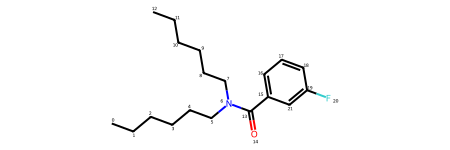

In [13]:
m = Chem.MolFromSmiles(s)
for at in m.GetAtoms():
    at.SetProp('atomNote', f"{at.GetIdx()}")  

m

In [14]:
s = Chem.MolToSmiles(m)
s

'CCCCCCN(CCCCCC)C(=O)c1cccc(F)c1'

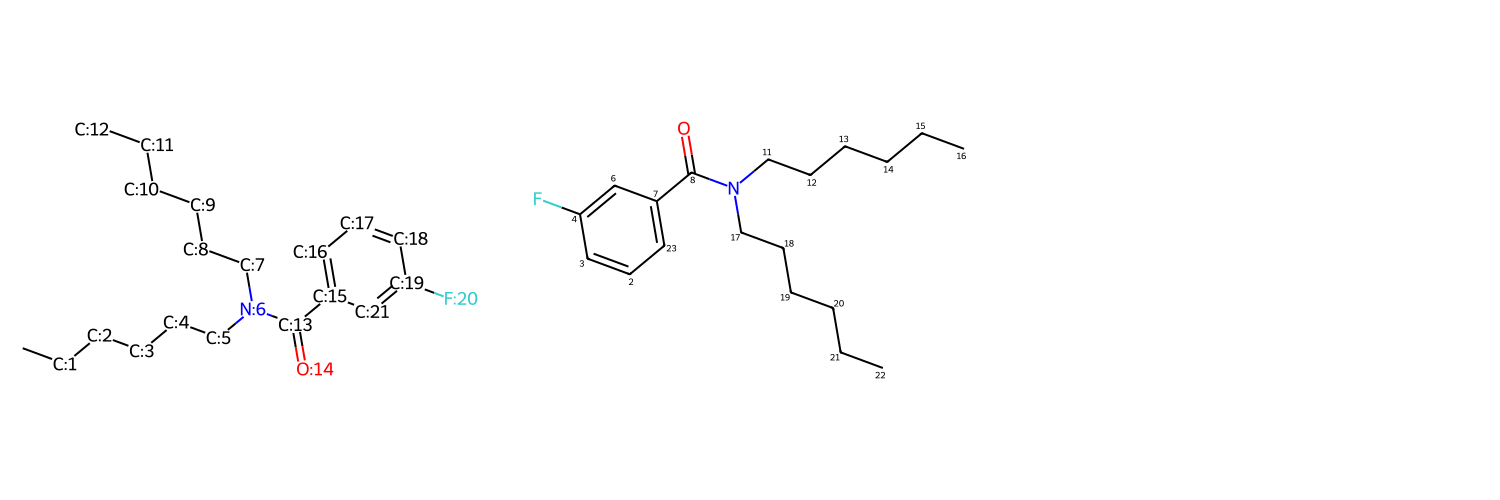

In [15]:
idx_to_rxn  = pp.atom_idx_to_rxn_map(s, r_map, draw=True)

In [19]:
from tqdm import tqdm
import numpy as np
df = boron_regio

In [33]:
for idx in df.index:
    if df.loc[idx, 'Selectivity (%)'] == df.loc[idx, 'Selectivity (%)']:
        df.loc[idx, 'Selectivity (%)'] = float(df.loc[idx, 'Selectivity (%)']) 
    elif df.loc[idx, 'Yield (%)'] == df.loc[idx, 'Yield (%)']:
        df.loc[idx, 'Selectivity (%)'] = float(df.loc[idx, 'Yield (%)'])
    else:
        df.drop(index = [idx], inplace=True) 
df.reset_index(drop=True, inplace=True)

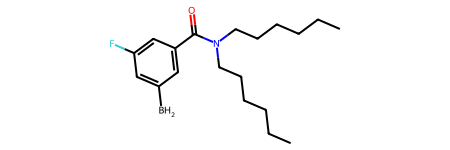

In [36]:
Chem.MolFromSmiles("Bc1cc(F)cc(C(=O)N(CCCCCC)CCCCCC)c1")


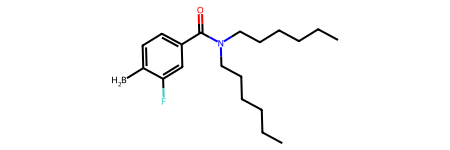

In [37]:
Chem.MolFromSmiles("Bc1ccc(C(=O)N(CCCCCC)CCCCCC)cc1F")

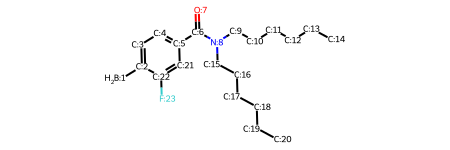

In [39]:
Chem.MolFromSmiles("[BH2:1][c:2]1[cH:3][cH:4][c:5]([C:6](=[O:7])[N:8]([CH2:9][CH2:10][CH2:11][CH2:12][CH2:13][CH3:14])[CH2:15][CH2:16][CH2:17][CH2:18][CH2:19][CH3:20])[cH:21][c:22]1[F:23]")


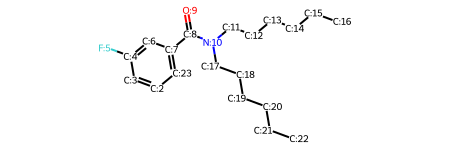

In [41]:
Chem.MolFromSmiles(r_map)

In [42]:
# make a single dictionnary per reaction:
selectivities_f = []
count = 0
idx = 30
df_red  = df[df.loc[:, 'rxn_ID'] == idx]
idx_rxn = df_red.index.to_list()
df_red.reset_index(inplace=True)
print(df_red.Reactant_SMILES.unique()[0])

red_sels = []
for idx_ in df_red.index:
    map_reactivity = pp.reactive_carbon(r_map, p_map, product_atom="B")
    print(map_reactivity)
    sel       = pp.get_selectivity(map_reactivity, idx_to_rxn, df.loc[idx, 'Selectivity (%)'])
    print(sel)
    sym_group = group_symmetric_atoms(s)[1]
    print(sym_group)
    group_idx = pp.get_idx_per_groups(sym_group)
    print(group_idx)
    red_sel_  = {}
    for key, value in group_idx.items():
        red_sel_[min(value)] = np.mean([sel[v] for v in value])
    red_sels.append(red_sel_)
red_sel = {}
for key in red_sels[0].keys():
    try:
        red_sel[key] = np.sum([red[key] for red in red_sels])
    except:
        raise ValueError(f"Error in the sum of the selectivities for reaction {idx}")

# normalize red_sel so that the sum equals 100

sum_sel = np.sum(list(red_sel.values())) 
if sum_sel == 0:
    print(idx, red_sel, sum_sel)
    count += 1

for key, value in red_sel.items():
    red_sel[key] = 100*value/sum_sel
    
for idx_ in idx_rxn:
    selectivities_f.append(red_sel)

CCCCCCN(CCCCCC)C(=O)c1cccc(F)c1
{2: True, 3: False, 4: False, 6: False, 7: False, 8: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False, 20: False, 21: False, 22: False, 23: False}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 15: 0.0, 16: 0.0, 17: 50.0, 18: 0.0, 19: 0.0, 21: 0.0}
{0: 0, 1: 8, 2: 10, 3: 12, 4: 14, 5: 16, 7: 16, 8: 14, 9: 12, 10: 10, 11: 8, 12: 0, 13: 18, 15: 20, 16: 6, 17: 4, 18: 5, 19: 19, 21: 7}
{0: [0, 12], 8: [1, 11], 10: [2, 10], 12: [3, 9], 14: [4, 8], 16: [5, 7], 18: [13], 20: [15], 6: [16], 4: [17], 5: [18], 19: [19], 7: [21]}
{2: True, 3: False, 4: False, 6: False, 7: False, 8: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False, 20: False, 21: False, 22: False, 23: False}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 15: 0.0, 16: 

In [43]:
red_sel

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 13: 0.0,
 15: 0.0,
 16: 0.0,
 17: 100.0,
 18: 0.0,
 19: 0.0,
 21: 0.0}

In [26]:
red_sel

{0: nan,
 1: nan,
 2: nan,
 3: nan,
 4: nan,
 5: nan,
 13: nan,
 15: nan,
 16: nan,
 17: nan,
 18: nan,
 19: nan,
 21: nan}

In [16]:
idx_to_rxn

{0: 16,
 1: 15,
 2: 14,
 3: 13,
 4: 12,
 5: 11,
 7: 17,
 8: 18,
 9: 19,
 10: 20,
 11: 21,
 12: 22,
 13: 8,
 15: 7,
 16: 23,
 17: 2,
 18: 3,
 19: 4,
 21: 6}

In [17]:
len({0: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 48.148148148148145, 6: 51.85185185185186, 7: 0.0, 8: 0.0, 9: 0.0})

9